In [1]:
### standard sci-py libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot ### to read, convert, inspect ROOT TTrees
import matplotlib as mpl

from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml import analysis_utils
from hipe4ml import plot_utils

import matplotlib.ticker as mtick # for 1e10 format on Axis


In [1]:
# Loading the datasets

hdl_mc = TreeHandler("/eos/user/h/hsharma/HyperLoop_Output_Run3/MC_train_112361_LHC22b1b/LcSignal.root", "LcSignal")
hdl_data = TreeHandler("/eos/user/h/hsharma/HyperLoop_Output_Run3/DATA_train_Lc_112997/LcData_df_0_40.root", "LcData")

# removing extra tails which are far from signal region

hdl_data.apply_preselections("fM > 2.2 and fM < 2.4", inplace=True)
hdl_mc.apply_preselections("fM > 2.2 and fM < 2.4", inplace=True)

NameError: name 'TreeHandler' is not defined

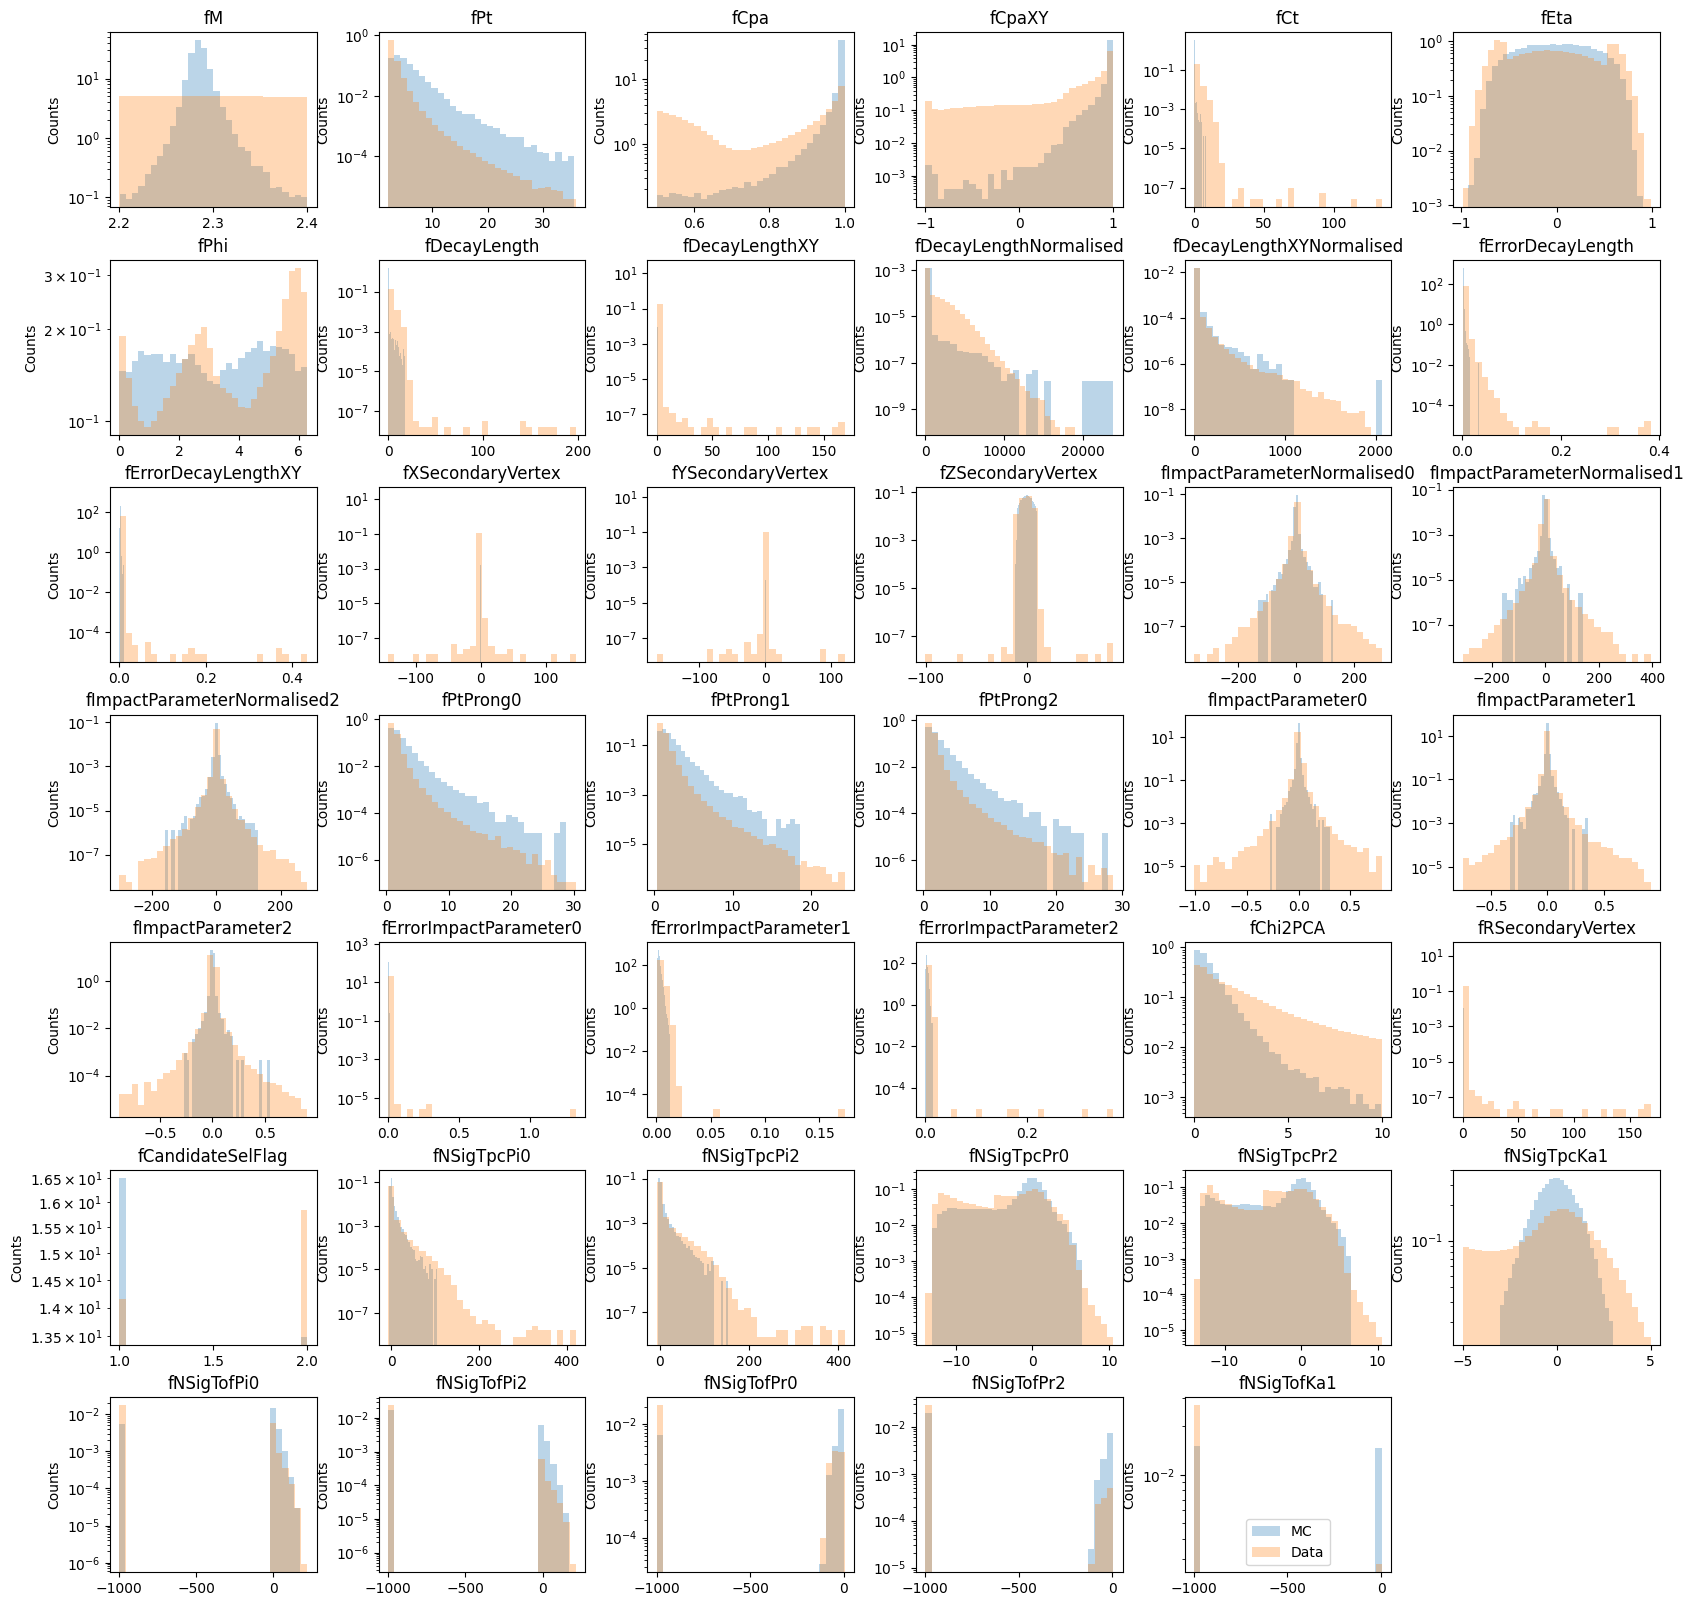

In [3]:
cols_to_be_compared = ['fM','fPt','fCpa','fCpaXY','fCt','fEta','fPhi', 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised', 'fDecayLengthXYNormalised',  'fErrorDecayLength', 'fErrorDecayLengthXY', 
                            'fXSecondaryVertex', 'fYSecondaryVertex','fZSecondaryVertex',
                           'fImpactParameterNormalised0', 'fImpactParameterNormalised1', 'fImpactParameterNormalised2',
                           'fPtProng0', 'fPtProng1', 'fPtProng2',
                           'fImpactParameter0', 'fImpactParameter1','fImpactParameter2',
                           'fErrorImpactParameter0', 'fErrorImpactParameter1', 'fErrorImpactParameter2', 'fChi2PCA', 'fRSecondaryVertex', 'fCandidateSelFlag',
                           'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
                           'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1'
                      ]


plot_utils.plot_distr([hdl_mc, hdl_data], cols_to_be_compared, 
                      bins=30, labels=['MC', 'Data'],
                      log=1, density=1, figsize=(20, 20), alpha=0.3, grid=False);

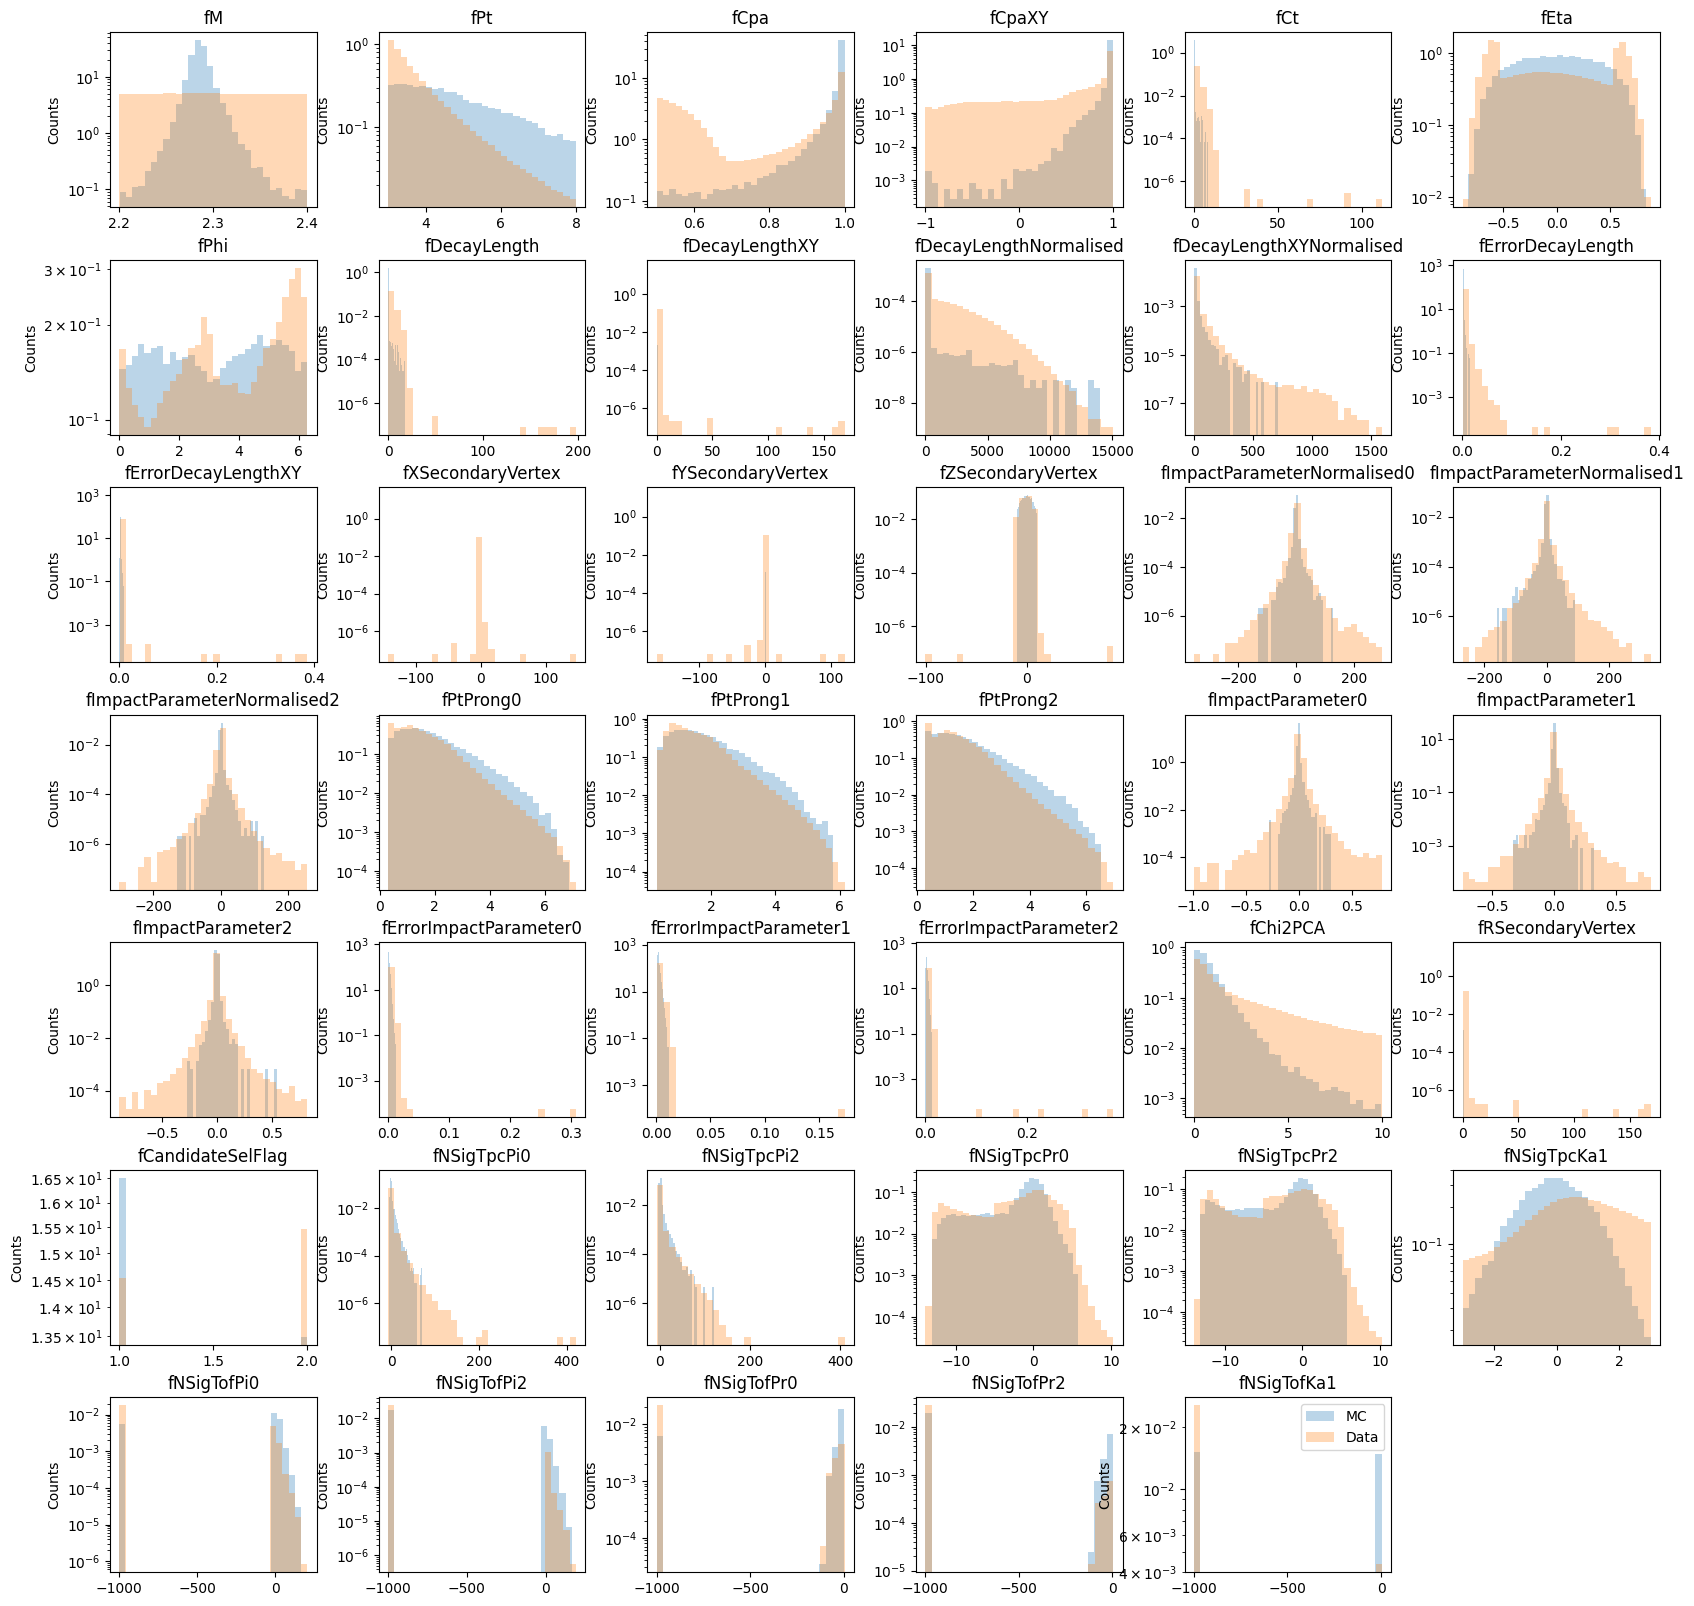

In [4]:
# Using Tight selection for data

tpcSigKa_min = -3
tpcSigKa_max = 3

pt_min = 3
pt_max = 8

cpa_min=0.9
cpa_max=1.0


cutList=[
    f'fNSigTpcKa1 > {tpcSigKa_min}',
    f'fNSigTpcKa1 < {tpcSigKa_max}',
    f'fPt > {pt_min}',
    f'fPt < {pt_max}',
#     f'fCpa > {cpa_min}',    
#     f'fCpa < {cpa_max}'
]
allCuts = ' & '.join(cutList)
allCuts = f' {allCuts} '  # Add spaces around the string

# Applying the same Tight selection criteira for data and MC
hdl_data.apply_preselections(allCuts, inplace=True)
hdl_mc.apply_preselections(allCuts, inplace=True)

plot_utils.plot_distr([hdl_mc, hdl_data], cols_to_be_compared, 
                      bins=30, labels=['MC', 'Data'],
                      log=1, density=1, figsize=(20, 20), alpha=0.3, grid=False);

In [5]:
# Selecting Bkg from given dataset
# Signal region for Lc is removed, ~ 5 sigma around the signal i.e. Mass = 2.284 GeV/c^2 

hdl_bkg = hdl_data.apply_preselections("fM < 2.26 or fM > 2.31", inplace=False)

# Only a fraction of total Bkg is used in BDT training and testing
# the fraction is given by `fractionData` 

fractionData=0.05 # this is the fraction of total data used in training 

hdl_bkg.shuffle_data_frame(frac=fractionData, inplace=True)
print('Size of samples for training \nBkg = ',len(hdl_bkg), ', Signal = ', len(hdl_mc))

Size of samples for training 
Bkg =  67530 , Signal =  54499


In [6]:
# the entries from `hdl_data` used in BDT training, taken out from the rest of sample.
#  `hdl_data_application` is created for applicaiton of the trained BDT

# cloning the dataset in handler format 
hdl_data_application = hdl_data

# convering dataset into pandas
df_totalData = hdl_data.get_data_frame()
df_BDTTraining = hdl_bkg.get_data_frame()

# dataset for the appication: dropping the dataset used for BDT training
df_application = pd.concat([df_totalData,df_BDTTraining]).drop_duplicates(keep=False)

# converting the pandas dataframe into handler format 
hdl_data_application.set_data_frame(df_application)

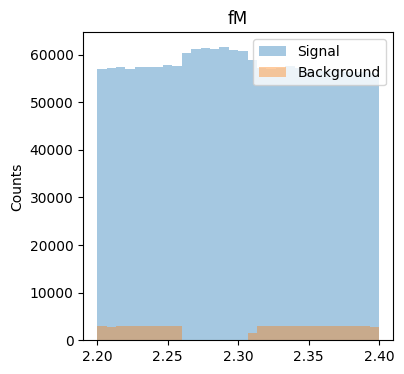

In [7]:
plot_utils.plot_distr([hdl_data_application,hdl_bkg], 'fM', 
                      bins=30, labels=['Signal', 'Background','sd'],
                      log=0, density=0, figsize=(4, 4), alpha=0.4, grid=False);

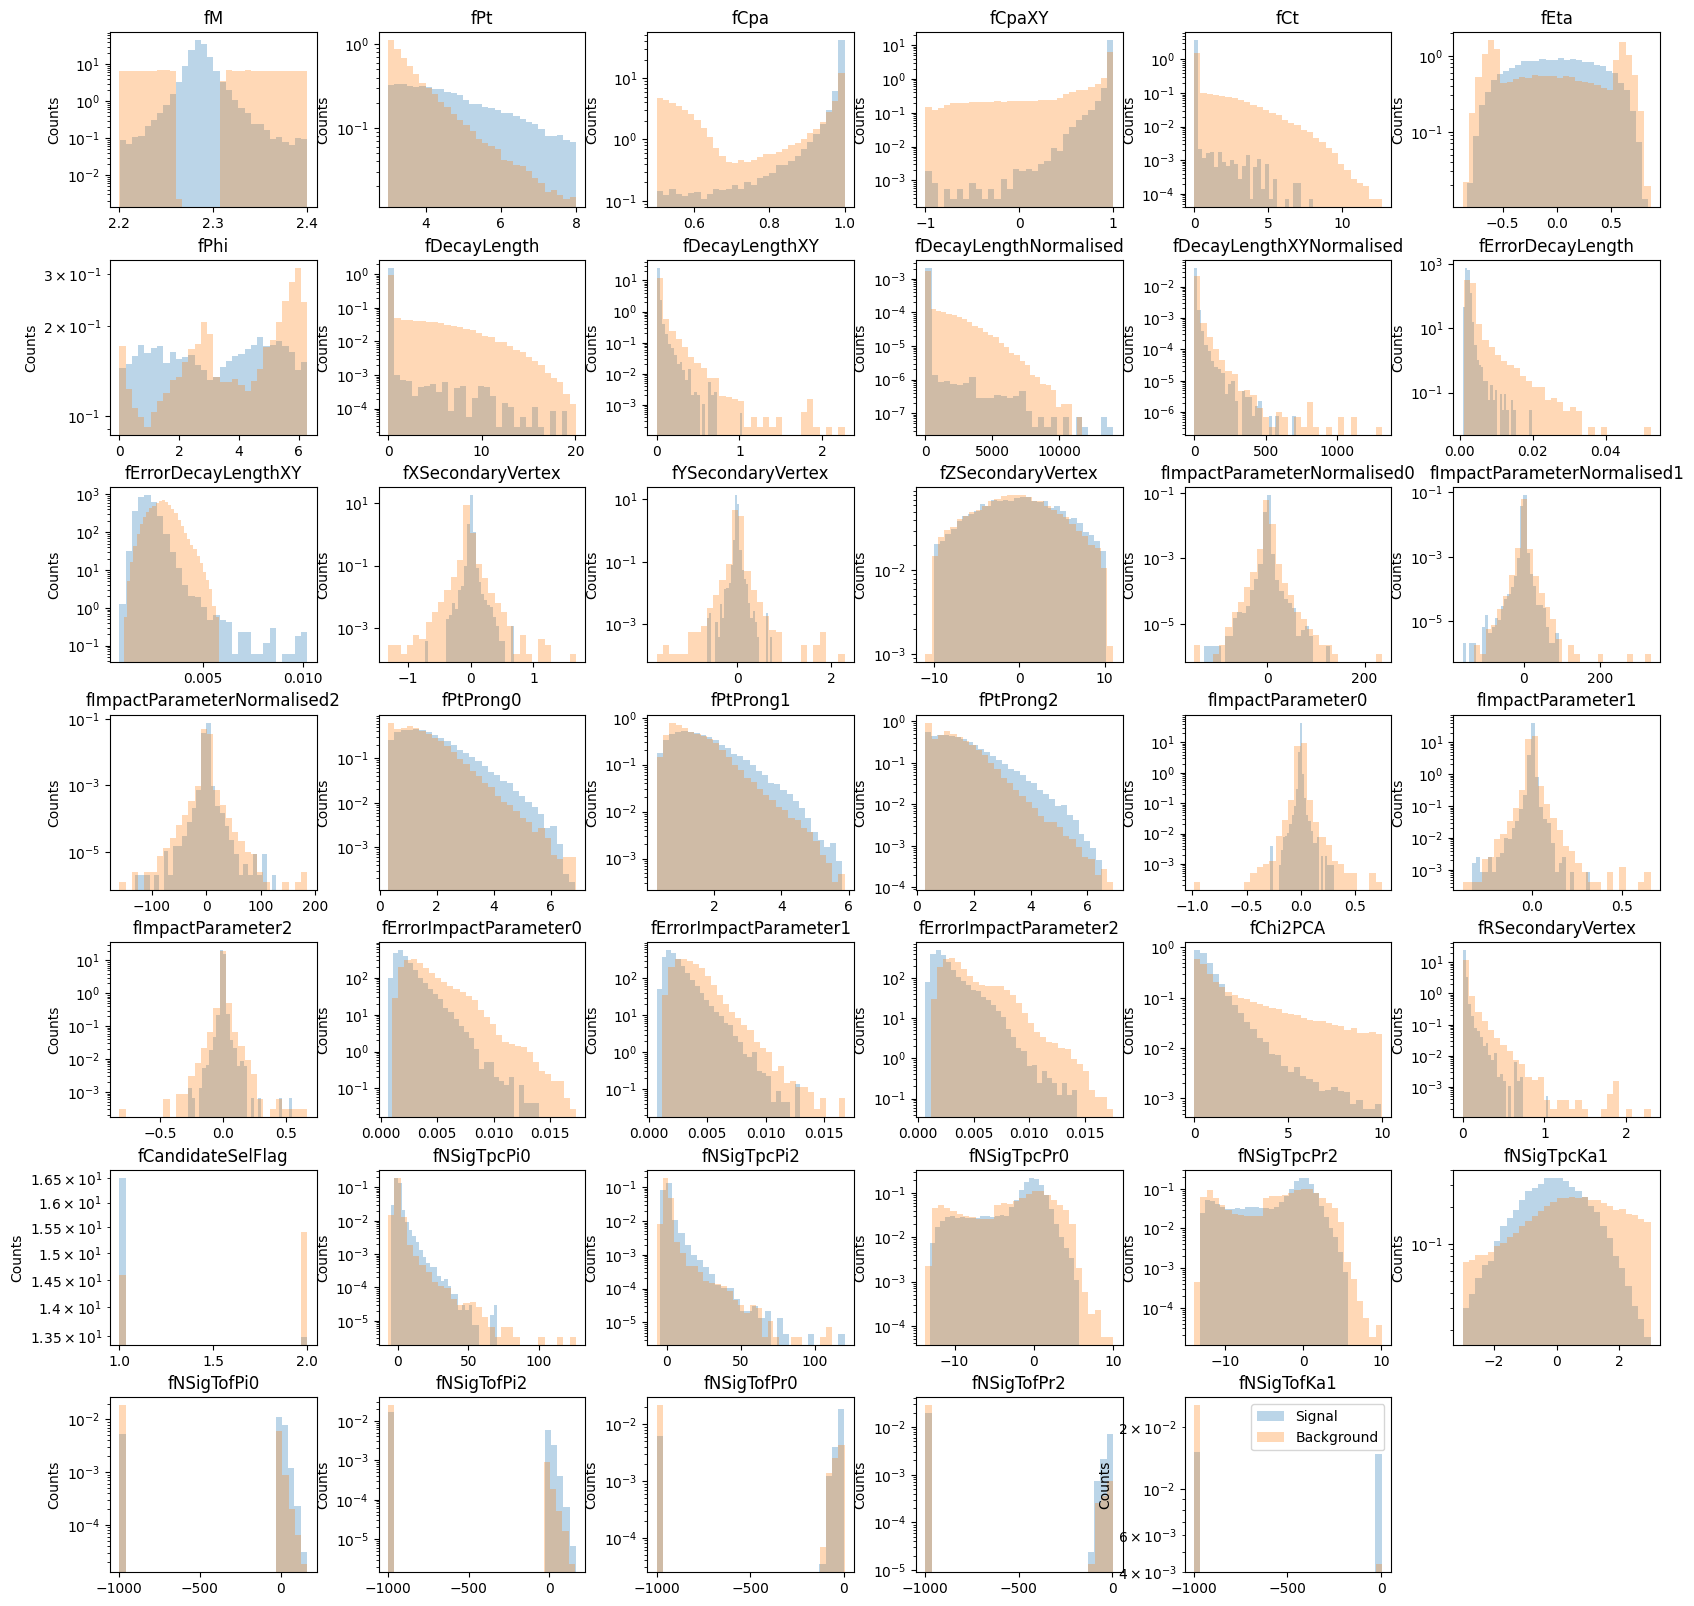

In [42]:
cols_to_be_compared = ['fM','fPt','fCpa','fCpaXY','fCt','fEta','fPhi', 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised', 'fDecayLengthXYNormalised',  'fErrorDecayLength', 'fErrorDecayLengthXY', 
                            'fXSecondaryVertex', 'fYSecondaryVertex','fZSecondaryVertex',
                           'fImpactParameterNormalised0', 'fImpactParameterNormalised1', 'fImpactParameterNormalised2',
                           'fPtProng0', 'fPtProng1', 'fPtProng2',
                           'fImpactParameter0', 'fImpactParameter1','fImpactParameter2',
                           'fErrorImpactParameter0', 'fErrorImpactParameter1', 'fErrorImpactParameter2', 'fChi2PCA', 'fRSecondaryVertex', 'fCandidateSelFlag',
                           'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
                           'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1'
                      ]

# ## some matplotlib tuning is needed to display all the features
plot_utils.plot_distr([hdl_mc, hdl_bkg], cols_to_be_compared, 
                      bins=30, labels=['Signal', 'Background'],
                      log=1, density=True, figsize=(20, 20), alpha=0.3, grid=False);

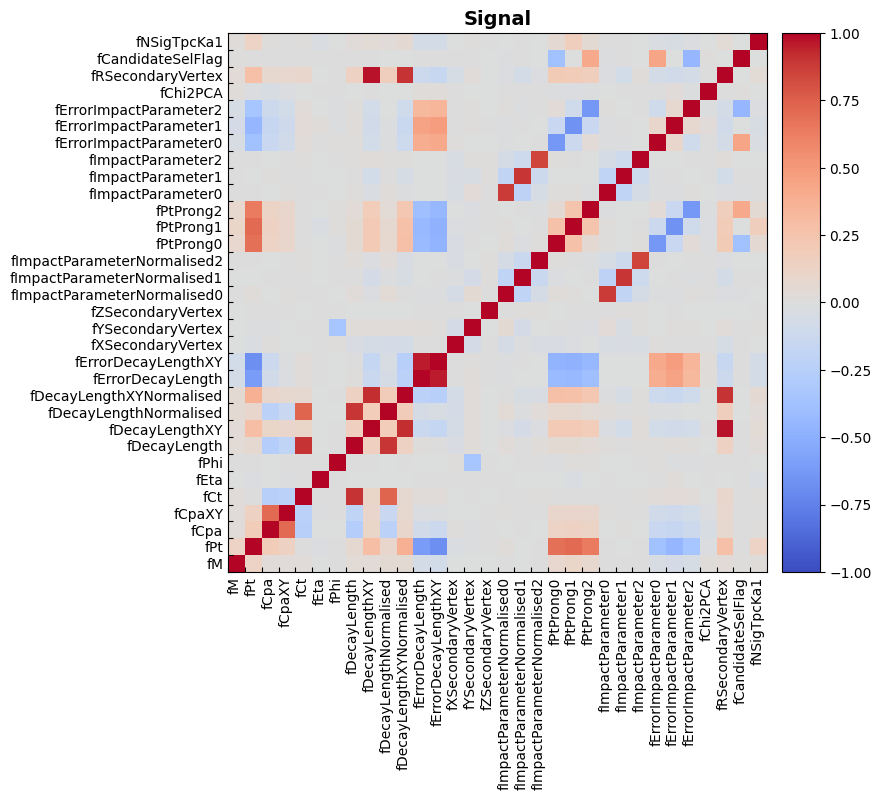

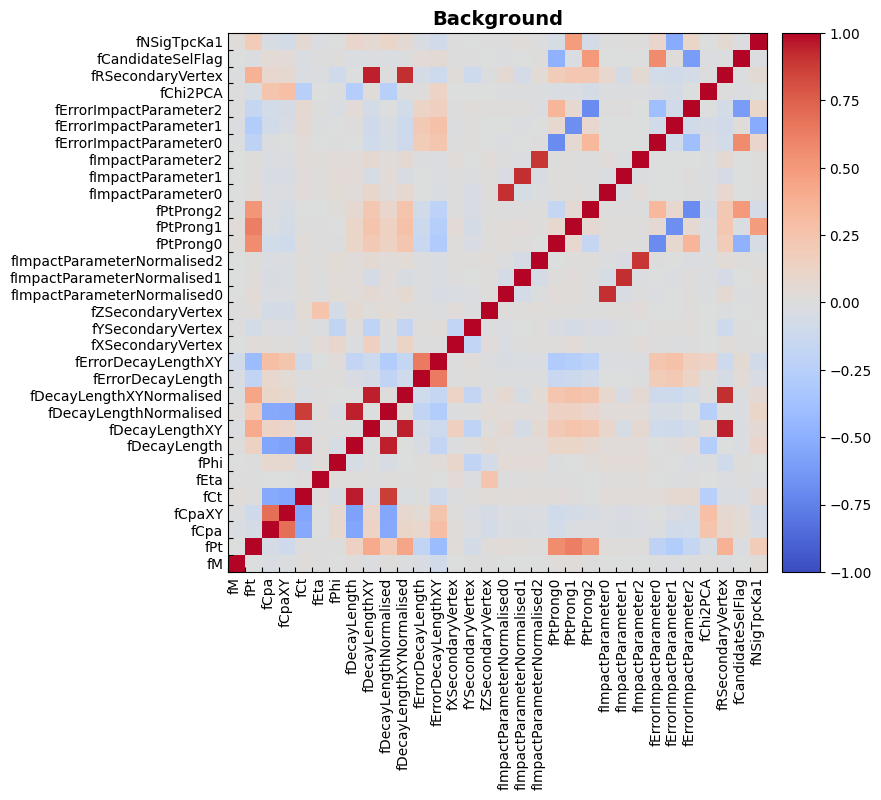

In [6]:
plot_utils.plot_corr([hdl_mc, hdl_bkg], cols_to_be_compared, labels=['Signal', 'Background']);

In [43]:
# training_cols = ['fCpa','fCpaXY','fCt','fEta','fPhi', 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised','fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
#                 'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1', 'fErrorDecayLength' , 'fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']

# training_cols = ['fCpa','fCt','fDecayLength', 'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1','fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']
# training_cols = ['fCpa','fCt','fDecayLength', 'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1','fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']
training_cols = ['fCpa','fCpaXY','fPt',
                 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised', 'fDecayLengthXYNormalised',
                 'fCt',
                 'fXSecondaryVertex', 'fYSecondaryVertex','fZSecondaryVertex',
                           'fImpactParameterNormalised0', 'fImpactParameterNormalised1', 'fImpactParameterNormalised2',
                           'fPtProng0', 'fPtProng1', 'fPtProng2',
                           'fImpactParameter0', 'fImpactParameter1','fImpactParameter2',
                           'fErrorImpactParameter0', 'fErrorImpactParameter1', 'fErrorImpactParameter2',
                 'fNSigTpcKa1',
#                  'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1',
#                  'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
                 'fChi2PCA',
                 'fRSecondaryVertex'
                 
                ]
# train_test_data is a combined dataset of data and MC
train_test_data = analysis_utils.train_test_generator([hdl_bkg, hdl_mc], [0, 1], test_size=0.4, random_state=42)

print('Size of train sample: ', len(train_test_data[0]))
print('Size of test sample: ', len(train_test_data[3]))


Size of train sample:  73217
Size of test sample:  48812


## Training and testing a BDT

We will use the BDT of XGBoost (https://github.com/dmlc/xgboost): boosting is implemented with a gradient descent method. It features few hyperparameters that can be tuned to improve the performance and reduce the overfitting, even if the algorithm works smoothly out of the box.



In [95]:
import xgboost as xgb
n_estimators=44
max_depth=1
learning_rate=0.06

xgb_model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

model_hdl = ModelHandler(xgb_model, training_cols)

## Optimize the model on the provided data

from optuna.samplers import RandomSampler

N_JOBS=8

hyper_pars_ranges = {'n_estimators': (20, 300), 'max_depth': (2, 6), 'learning_rate': (0.01, 0.1)}
rnd_study = model_hdl.optimize_params_optuna(train_test_data, hyper_pars_ranges, cross_val_scoring='roc_auc',
                                             timeout=60, n_jobs=N_JOBS, n_trials=20, direction='maximize',
                                             optuna_sampler=RandomSampler())

In [94]:
from optuna.samplers import RandomSampler

N_JOBS=-1

hyper_pars_ranges = {'n_estimators': (20, 200), 'max_depth': (1, 3), 'learning_rate': (0.01, 0.4)}
rnd_study = model_hdl.optimize_params_optuna(train_test_data, hyper_pars_ranges, cross_val_scoring='roc_auc',
                                             timeout=60, n_jobs=N_JOBS, n_trials=20, direction='maximize',
                                             optuna_sampler=RandomSampler())

[I 2023-08-15 18:42:42,221] A new study created in memory with name: no-name-bf3d6f88-e8e7-4ed0-b375-2544bf6f5f45
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

Number of finished trials: 20
Best trial:
Value: 0.9999278687937455
Params: 
    n_estimators: 188
    max_depth: 3
    learning_rate: 0.32584220367404565


In [96]:
model_hdl.fit(train_test_data[0], train_test_data[1])

In [97]:
score_test = model_hdl.predict(train_test_data[2])

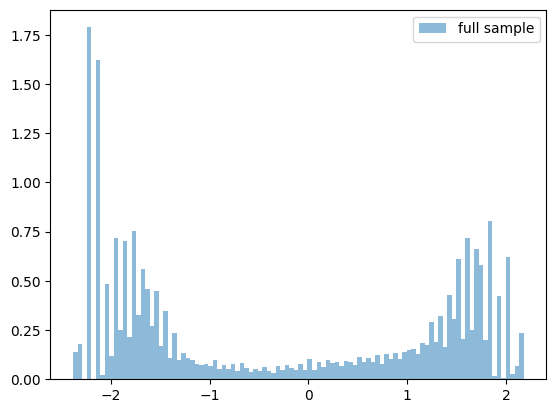

In [98]:
#### plot the score distribution
plt.hist(score_test, bins=100, label='full sample', alpha=0.5, density=True);
plt.legend();

Two peaks clearly distinguishable: will they be corresponding to the signal and the background? Let's plot the two distribution separately

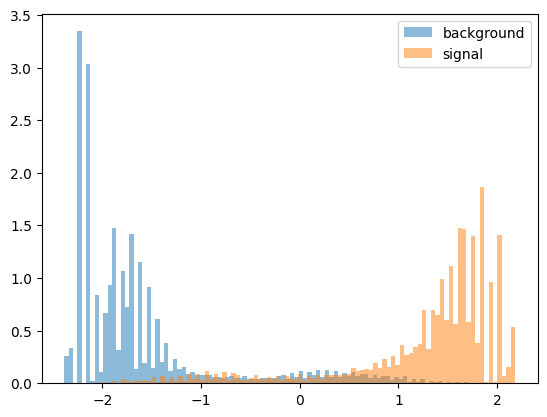

In [99]:
plt.hist(score_test[train_test_data[3]==0], bins=100, label='background', alpha=0.5, density=True);
plt.hist(score_test[train_test_data[3]==1], bins=100, label='signal', alpha=0.5, density=True);
plt.legend();


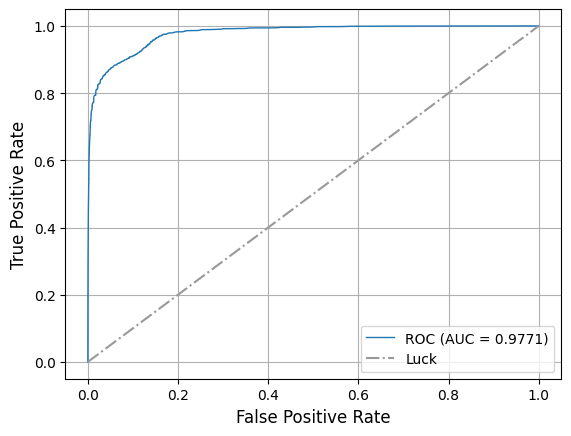

In [100]:
plot_utils.plot_roc(train_test_data[3], score_test);

Repeat this exercise with the training set: what do you get?

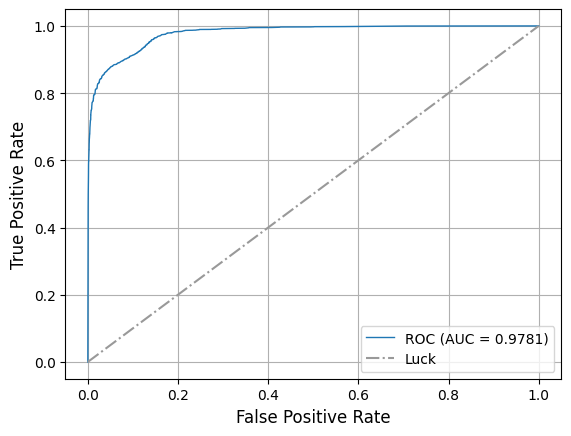

In [101]:
score_train = model_hdl.predict(train_test_data[0])
plot_utils.plot_roc(train_test_data[1], score_train);

Training ROC-AUC is slightly higher than the test set one. This is a systematic behaviour due to the small presence of overfitting. We can see it also by plotting the BDT output for the training and test set distributions

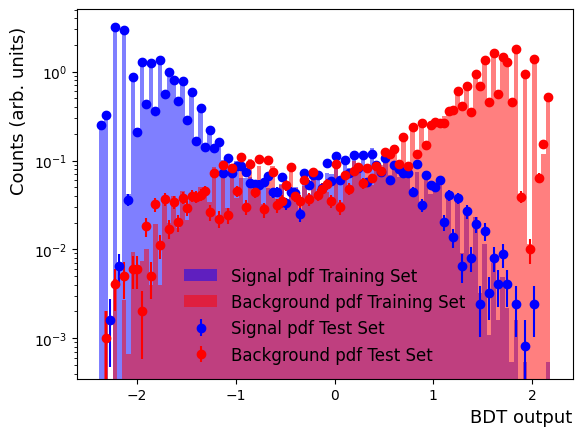

In [102]:
plot_utils.plot_output_train_test(model_hdl, train_test_data, density=True, bins=100, logscale=True);

Now, before applying the BDT to data we can have a look at which variables are relevant for the training. We will use the feature importance implemented in the SHAP library (https://github.com/slundberg/shap). In the context of machine learning, the Shapley value is used to evaluate the contribution of each feature to the model output, and it is calculated by averaging the marginal contributions of each feature to the model output. The marginal contribution of a feature is the difference in the model output when the feature is present or absent. The variables that are
more important for the model are those that have a higher marginal contribution, and Shapley values consequently.

In hipe4ml the function plot_feat_imp implements the algorithm: try to use it!

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


[<Figure size 1800x900 with 2 Axes>, <Figure size 1800x900 with 1 Axes>]

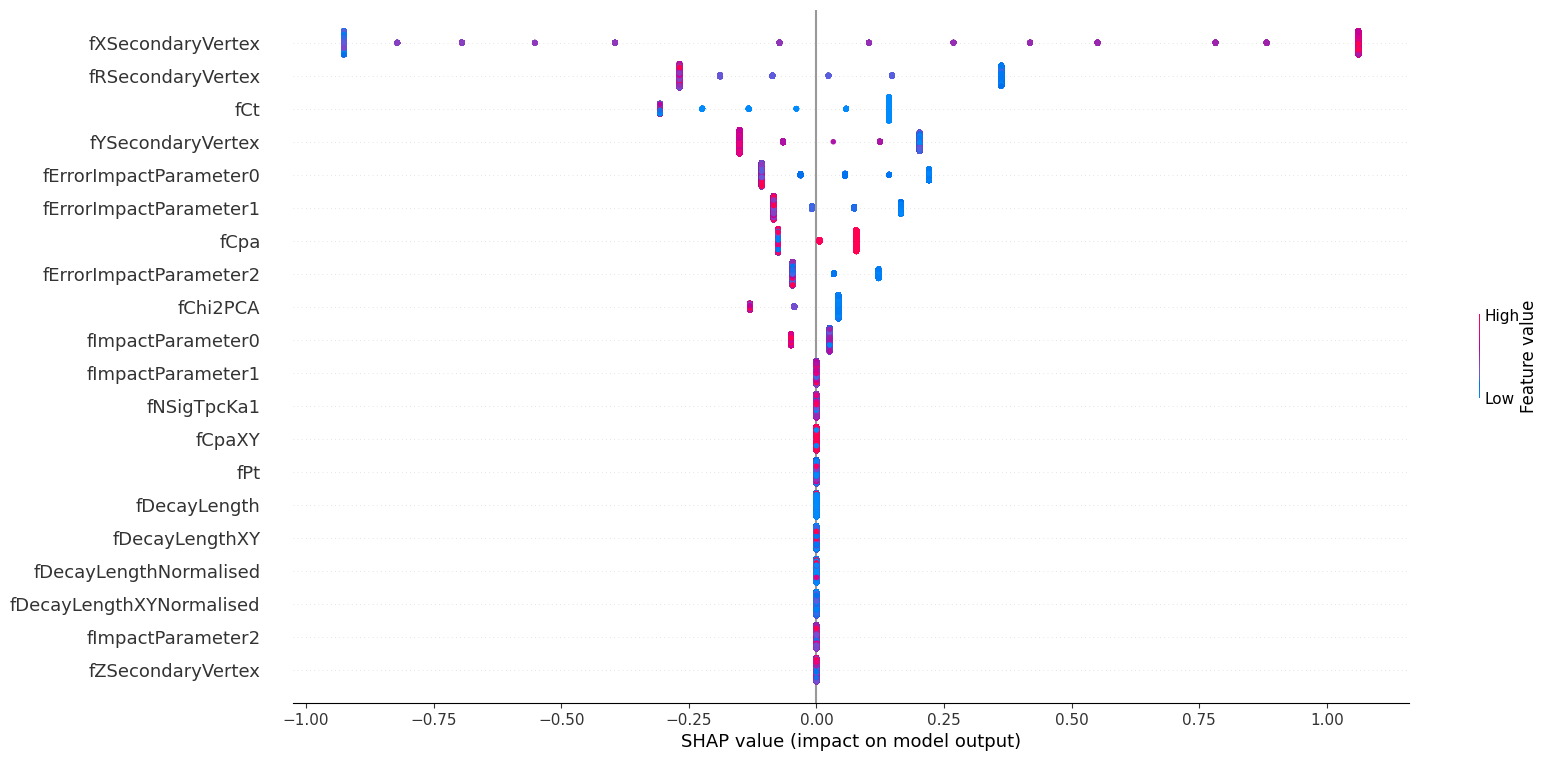

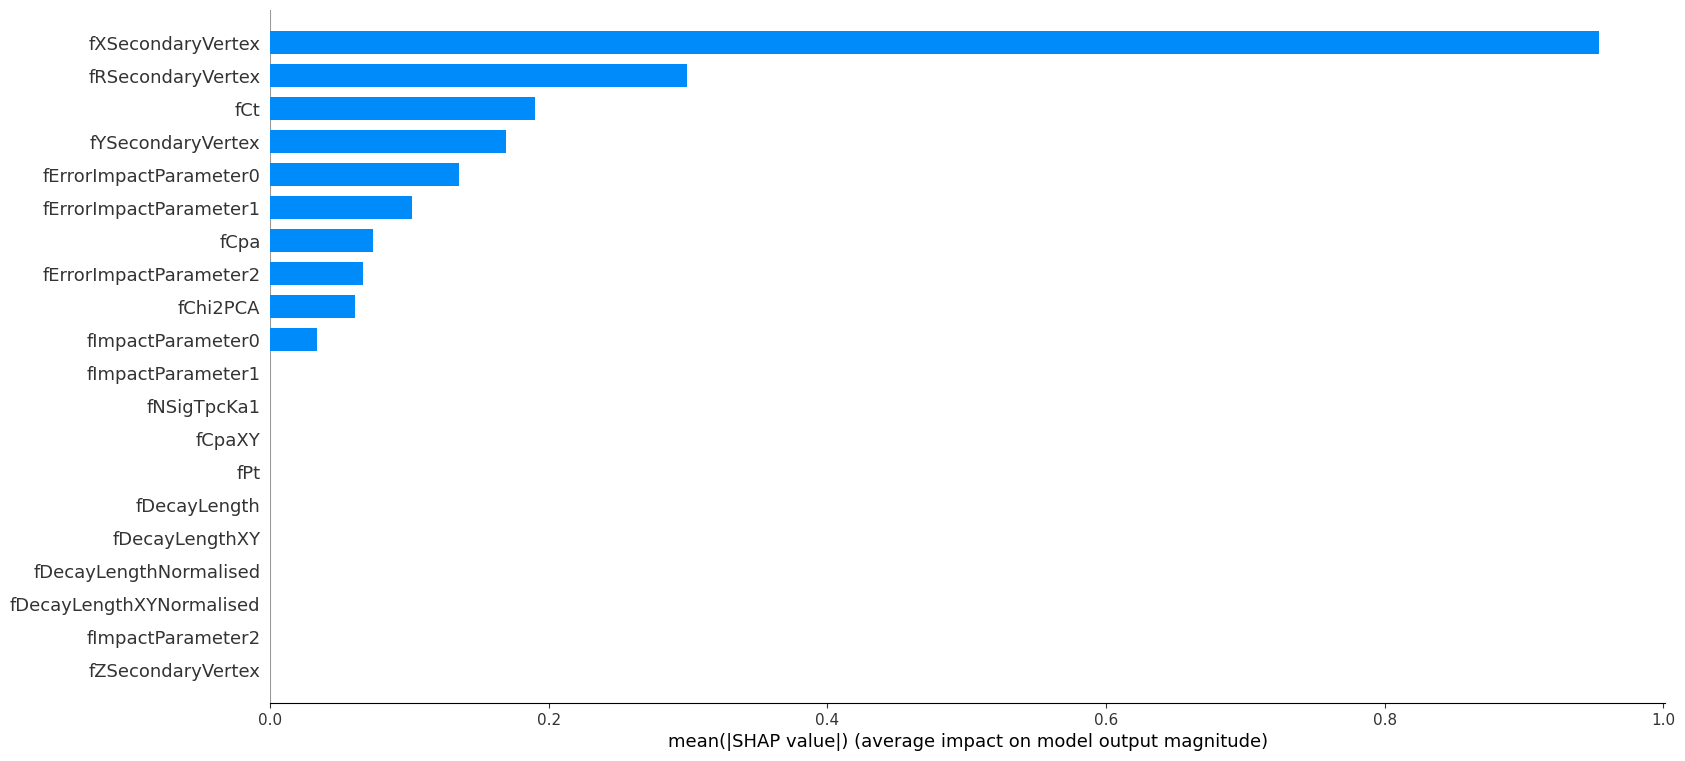

In [104]:
plot_utils.plot_feature_imp(train_test_data[2], train_test_data[3], model_hdl) 

### Applying the BDT

In [105]:
hdl_data_application.apply_model_handler(model_hdl)

output_df=hdl_data_application.get_data_frame()

minScore=round(output_df.model_output.min(),2)
maxScore=round(output_df.model_output.max(),2)

minhalf=round(minScore/2,2)
minquarter=round(minScore/4 * 3,2)
minextreme=round(minScore/8 * 7,2)

maxhalf=round(maxScore/2,2)
maxquarter=round(maxScore/4 * 3,2)
maxextreme=round(maxScore/8 * 7,2)

listScoreMin=[minScore, minScore, minScore, minScore,    minScore,   0,         maxhalf,   maxquarter, maxextreme ]
listScoreMax=[maxScore, 0,        minhalf,  minquarter,  minextreme, maxScore,  maxScore,  maxScore,   maxScore   ]

print(listScoreMin)
print(listScoreMax)

print(minScore, maxScore)

[-2.38, -2.38, -2.38, -2.38, -2.38, 0, 1.09, 1.64, 1.91]
[2.18, 0, -1.19, -1.79, -2.08, 2.18, 2.18, 2.18, 2.18]
-2.38 2.18


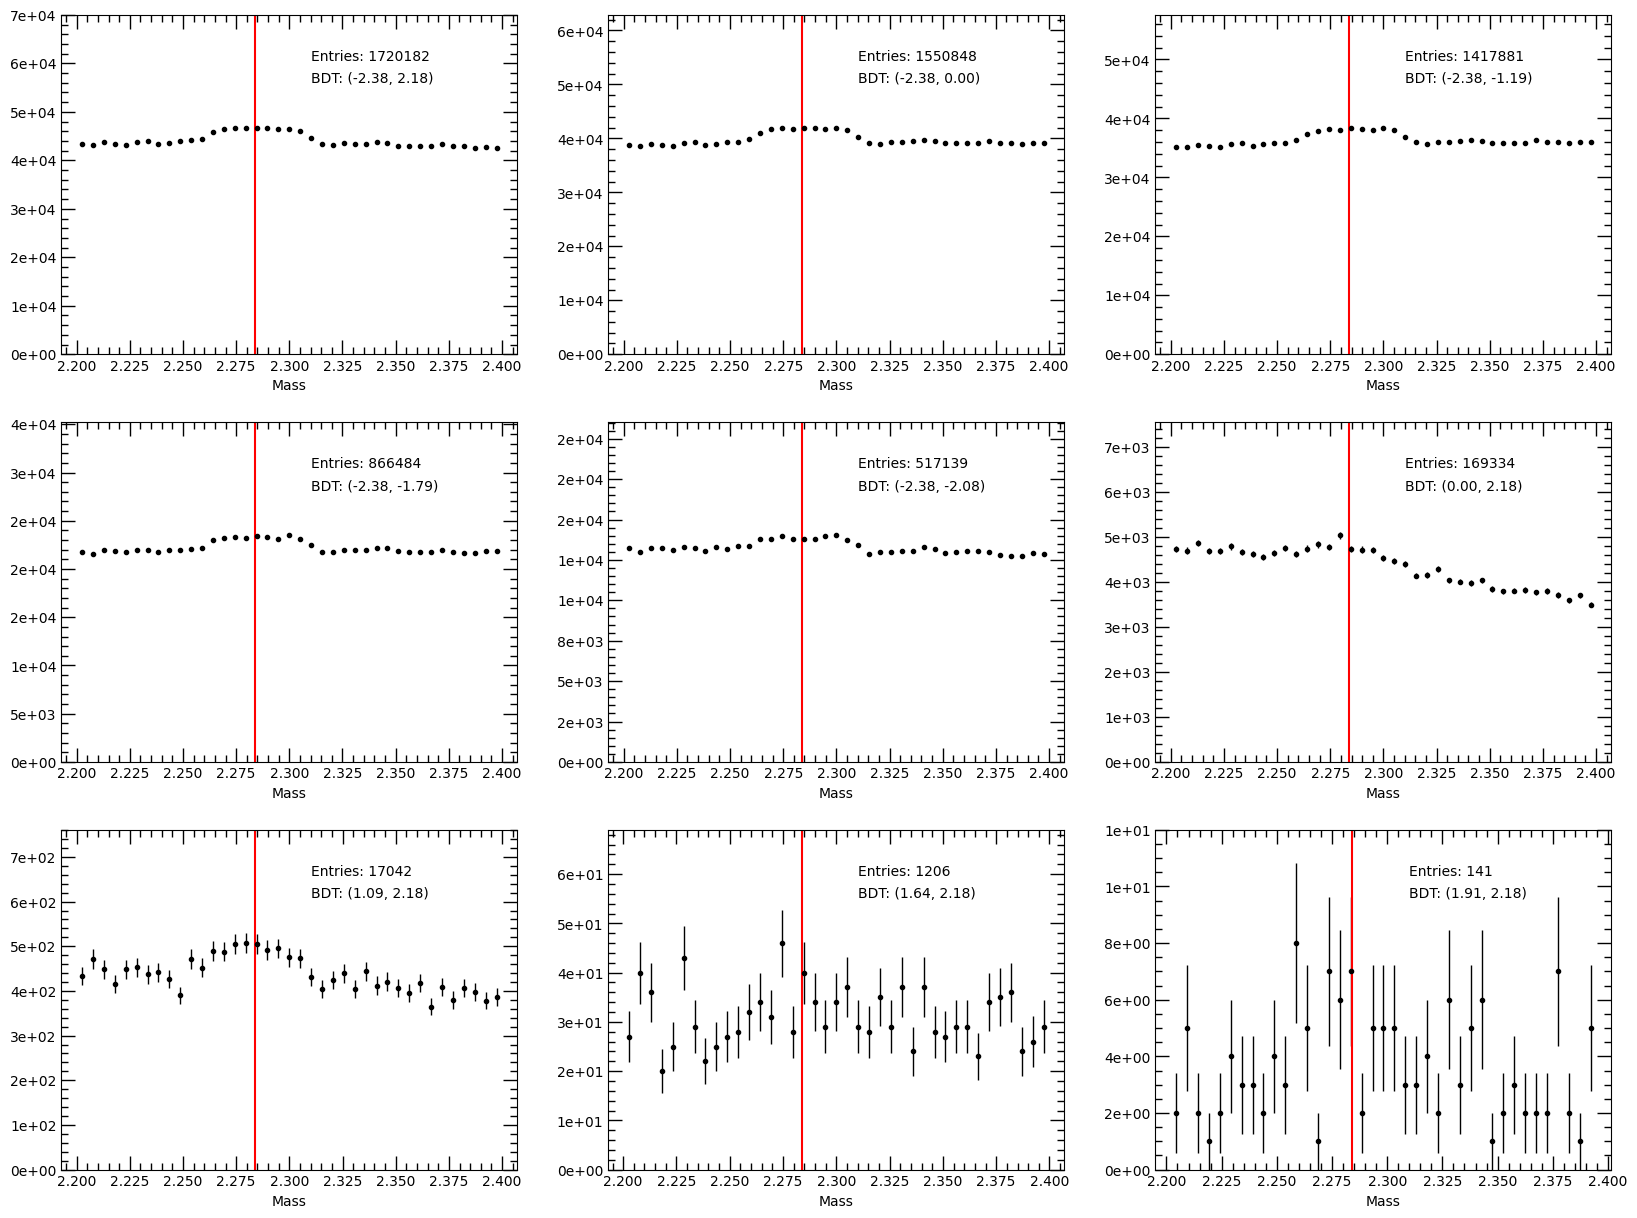

In [106]:
# --------- different score ranges ----------------

minScore=round(output_df.model_output.min(),2)
maxScore=round(output_df.model_output.max(),2)

minhalf=round(minScore/2,2)
minquarter=round(minScore/4 * 3,2)
minextreme=round(minScore/8 * 7,2)

maxhalf=round(maxScore/2,2)
maxquarter=round(maxScore/4 * 3,2)
maxextreme=round(maxScore/8 * 7,2)

listScoreMin=[minScore, minScore, minScore, minScore,    minScore,   0,         maxhalf,   maxquarter, maxextreme ]
listScoreMax=[maxScore, 0,        minhalf,  minquarter,  minextreme, maxScore,  maxScore,  maxScore,   maxScore   ]

#----------------

minMass=2.2
maxMass=2.4
binWidth=0.005 # GeV/c^2 ~ 4 MeV/c^2
binsInvMass=int((maxMass-minMass)/binWidth);


fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(20,15))
count=-1

for i in range(3):
    for j in range(3):
        count=count+1
        scoreMin=listScoreMin[count]
        scoreMax=listScoreMax[count]
        scoreCut=f'model_output > {scoreMin:.2f} & model_output < {scoreMax:.2f}'
        counts, bins = np.histogram(output_df.query(scoreCut)['fM'], bins=binsInvMass)
        x_point = 0.5 * (bins[1:] + bins[:-1])
        axes[i,j].errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='.', ecolor='k', color='k', elinewidth=1., label='Data')
        axes[i,j].axvline(2.284, 0, 1, label='pyplot vertical line',color='r')
        axes[i,j].set_xlabel('Mass')
#         axes[i,j].set_ylabel('Entries')
        axes[i,j].set_ylim(bottom=0)
        axes[i,j].set_ylim(top=counts.max()*1.5)
        axes[i,j].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e')) 
        axes[i,j].minorticks_on()
        textStr= f'BDT: ({scoreMin:.2f}, {scoreMax:.2f})'
        EntriesStr= f'Entries: {counts.sum()}'
        axes[i,j].text(2.31,counts.max()*1.2, textStr )
        axes[i,j].text(2.31,counts.max()*1.3, EntriesStr )
        axes[i,j].tick_params('both', top=True, right=True, direction='in',length=bigTicks, width=1, which='major')
        axes[i,j].tick_params('both', top=True, right=True, direction='in',length=smallTicks, width=1, which='minor')

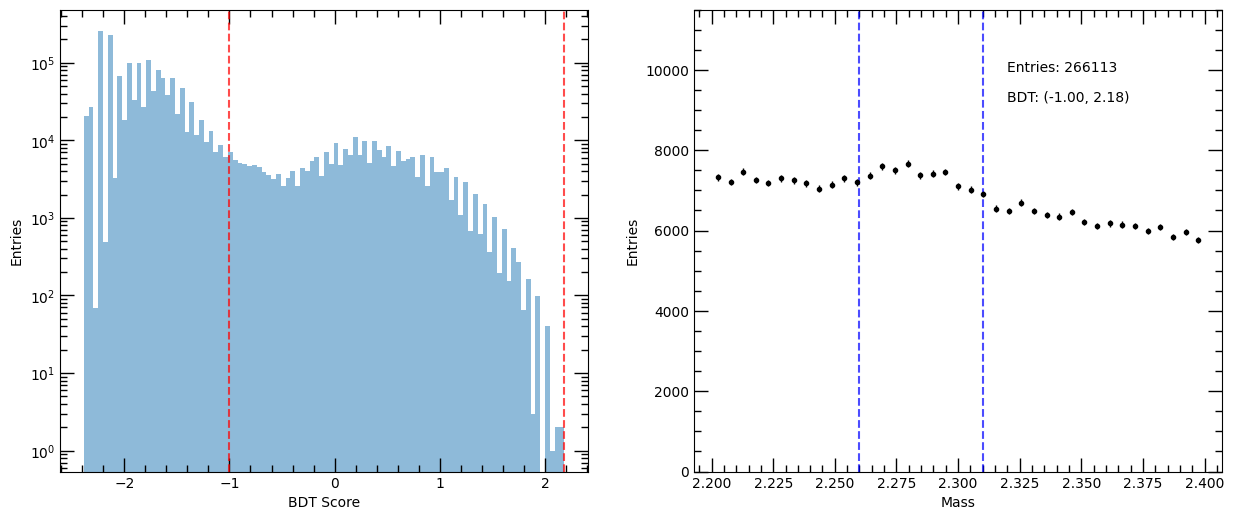

In [109]:
bigTicks=10
smallTicks=5

fig, ax = plt.subplots(1,2, figsize=(15,6))


scoreMin=-1
scoreMax=round(output_df.model_output.max(),2)


scoreCut=f'model_output > {scoreMin:.2f} & model_output < {scoreMax:.2f}'
ax[0].hist(output_df['model_output'],bins=100,alpha=0.5,log=1)
ax[0].minorticks_on()
ax[0].tick_params('both', top=True, right=True, direction='in',length=bigTicks, width=1, which='major')
ax[0].tick_params('both', top=True, right=True, direction='in',length=smallTicks, width=1, which='minor')
ax[0].axvline(scoreMin, 0, 1, label='pyplot vertical line',color='r',linestyle='--',alpha=0.7)
ax[0].axvline(scoreMax, 0, 1, label='pyplot vertical line',color='r',linestyle='--',alpha=0.7)
ax[0].set_ylabel('Entries')
ax[0].set_xlabel('BDT Score')


counts, bins = np.histogram(output_df.query(scoreCut)['fM'], bins=binsInvMass)
x_point = 0.5 * (bins[1:] + bins[:-1])
ax[1].errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='.', ecolor='k', color='k', elinewidth=1., label='Data')
ax[1].set_ylim(bottom=0)
ax[1].set_ylim(top=counts.max()*1.5)
ax[1].minorticks_on()
textStr= f'BDT: ({scoreMin:.2f}, {scoreMax:.2f})'
EntriesStr= f'Entries: {counts.sum()}'
ax[1].text(2.32,counts.max()*1.2, textStr )
ax[1].text(2.32,counts.max()*1.3, EntriesStr )
ax[1].tick_params('both', top=True, right=True, direction='in',length=bigTicks, width=1, which='major')
ax[1].tick_params('both', top=True, right=True, direction='in',length=smallTicks, width=1, which='minor')
ax[1].set_ylabel('Entries')
ax[1].set_xlabel('Mass')
ax[1].axvline(2.26, 0, 1, label='pyplot vertical line',color='b',linestyle='--',alpha=0.7)
ax[1].axvline(2.31, 0, 1, label='pyplot vertical line',color='b',linestyle='--',alpha=0.7)

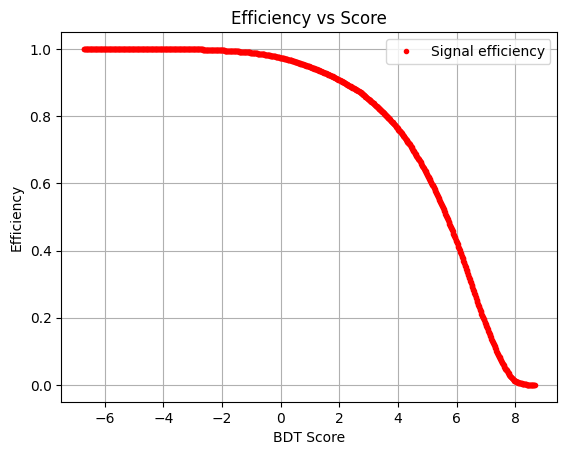

In [67]:
### hipe4ml has a function to do that! 
eff_array, score_array = analysis_utils.bdt_efficiency_array(train_test_data[3], score_test, 1000)
plot_utils.plot_bdt_eff(score_array, eff_array);

In [44]:
## Now we can try to fit the invariant mass spectrum

In [48]:
from scipy.optimize import curve_fit
from scipy import integrate

def fit_invmass(df, fit_range=[1.660, 1.685]):
    
    # histogram of the data
    counts, bins = np.histogram(df, bins=40, range=fit_range)
    
    # define functions for fitting    
    def gaus_function(x, N, mu, sigma):
        return N * np.exp(-(x-mu)**2/(2*sigma**2))
    
    def pol2_function(x, a, b):
        return (a + x*b)
    
    def fit_function(x, a, b, N, mu, sigma):
        return pol2_function(x, a, b) + gaus_function(x, N, mu, sigma)
    
    # x axis ranges for plots
    x_point = 0.5 * (bins[1:] + bins[:-1])
    r = np.arange(fit_range[0], fit_range[1], 0.00001)
    
    # fit the invariant mass distribution with fit_function() pol2+gauss
    popt, pcov = curve_fit(fit_function, x_point, counts, p0 = [100, -1, 100, 1.673, 0.001])
    
    # plot data
    plt.errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='.', ecolor='k', color='k', elinewidth=1., label='Data')
    
    # plot pol2 and gauss obtained in the fit separately
    plt.plot(r, gaus_function(r, N=popt[2], mu=popt[3], sigma=popt[4]), label='Gaus', color='red')
    plt.plot(r, pol2_function(r, a=popt[0], b=popt[1]), label='pol2', color='green', linestyle='--')

    # plot the global fit
    plt.plot(r, fit_function(r, *popt), label='pol2+Gaus', color='blue')
    
    # compute significance of the signal
    signal = integrate.quad(gaus_function, fit_range[0], fit_range[1], args=(popt[2], popt[3], popt[4]))[0] / 0.00225
    background = integrate.quad(pol2_function, fit_range[0], fit_range[1], args=(popt[0], popt[1]))[0] / 0.00225
    print(f'Signal counts: {signal:.0f}')
    print(f'Background counts: {background:.0f}')     
    significance = signal / np.sqrt(signal + background)

    # Add some axis labels
    plt.legend()
    plt.xlabel('$M_{\Lambda\pi}$ $(\mathrm{GeV/}\it{c}^2)$')
    plt.ylabel('Counts')
    plt.show()


In [49]:
fit_invmass(hdl_data.apply_preselections("model_output>4", inplace=False)["mass"], fit_range=[1.660, 1.685])

KeyError: 'mass'

In [ ]:
### you can also use some packages for implementing ROOT like plots in python
import mplhep as hep
hep.style.use(hep.style.ROOT)

In [ ]:
fit_invmass(hdl_data.apply_preselections("model_output>0.5", inplace=False)["mass"], fit_range=[1.660, 1.685])

In [ ]:
#### reset matplotlib style if needed
plt.style.use('default')